# **Pryecto Data Analytics: Siniestros Viales**

### **EDA: Análisis Exploratorio**

El prpósito de este notebook es analizar los datos proporcionados que fueron previamente transformados y están listos para ser observados con el rigor y detalle acorde al objetivo del proyecto.

El **objetivo principal** es adoptar el rol de analista y **extraer información** que le permita (potencialmente) a las autoridades locales tomar medidas para disminuir la cantidad de víctimas fatales en siniestros viales en la ciudad de Buenos Aires.

Dentro de los **objetivos** más **específicos** de esta parte exploratoria se encuentran:

- **Comprender** la organización de los datos.
- **Detectar** posibles anomalías y/o inconsistencias (valores faltantes, duplicados y valores atípicos).
- **Conocer** como se distribuyen los datos.
- **Determinar** patrones y relaciones entre las variables.
- **Extraer** conclusiones relevantes.

Al final las conclusiones extraídas deberán tener un alto nivel de importancia y serán la base para la creación del reporte final (un Dashboard de PowerBi).

In [1]:
import numpy as np 
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
# Leer los archivos resultantes del libro ETL
hechos = pd.read_csv('./data/homicidios_hechos.csv', na_values=['Sd', 'SD', '.',''])
victimas = pd.read_csv('./data/homicidios_victimas.csv', na_values=['Sd','.',''])

# Crear copias para no modificar los originales
df_hechos = hechos.copy()
df_victimas = victimas.copy()

Exploración de Hechos
---

Algunas medidas descriptivas: **Análisis Univariable**.

Metodología:

1. Convertir las columnas a los tipos de dato adecuados.
2. Detección y Exploración de datos faltantes.
3. Generación de estadísticas descriptivas.
    - Medidas de tendencia central.
    - Medidas de dispersión.
    - Gráficos para observar la distribución de los datos numéricos.

In [3]:
df_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID_hecho           696 non-null    object 
 1   Cantidad_Víctimas  696 non-null    int64  
 2   Fecha              696 non-null    object 
 3   Hora               695 non-null    float64
 4   Lugar_del_hecho    695 non-null    object 
 5   Tipo_de_calle      696 non-null    object 
 6   Comuna             694 non-null    float64
 7   Longitud           684 non-null    float64
 8   Latitud            684 non-null    float64
 9   Vehículo_Víctima   687 non-null    object 
 10  Vehiculo_Acusado   673 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 59.9+ KB


Exploración y Resumen de Valores Faltantes.

Una pérdida de datos importante **puede tener un impacto negativo** en el análisis. Por esto, es una buena idea repasar este apartado y tener una noción clara de las variables incompletas, y así tomar medidas para su tratamiento antes de proceder con el trabajo de análisis, evitando caer en cualquier tipo de sesgo. 

De igual forma se plantean hipótesis sobre los mecanismos bajo los cuales se está perdiendo la información, con el objetivo de **orientar este y futuros trabajos de análisis hacia los procedimientos de tratamiento e imputación adecuados**, determinando donde es posible ignorar la pérdida de información y donde es necesario tomar acciones preventivas para evitar la pérdida de datos.

¿Qué porcentajes de valores nulos se tienen?

In [4]:
print('Porcentaje de valores nulos por variable:')

((df_hechos.isnull().sum() / 696) * 100).apply(round, ndigits=2).astype('str') + ' %'

Porcentaje de valores nulos por variable:


ID_hecho              0.0 %
Cantidad_Víctimas     0.0 %
Fecha                 0.0 %
Hora                 0.14 %
Lugar_del_hecho      0.14 %
Tipo_de_calle         0.0 %
Comuna               0.29 %
Longitud             1.72 %
Latitud              1.72 %
Vehículo_Víctima     1.29 %
Vehiculo_Acusado      3.3 %
dtype: object

Obsérvese que la cantidad de nulos no representa una proporción importante para ninguna de las variables. Ninguna columna supera el 4% de faltantes en sus registros.

Resumen por variable.

`Lugar_del_hecho`

In [5]:
df_hechos[df_hechos['Lugar_del_hecho'].isnull()]

,ID_hecho,Cantidad_Víctimas,Fecha,Hora,Lugar_del_hecho,Tipo_de_calle,Comuna,Longitud,Latitud,Vehículo_Víctima,Vehiculo_Acusado
119,2016-0151,1,2016-11-18,20.0,NaN,Calle,NaN,NaN,NaN,Peaton,NaN


Hay un único registro cuyo ``Lugar_del_hecho`` se desconoce. Se plantea la hipótesis de que este valor está perdido completamente al azar (Missing Completely At Random), ya que su ausencia puede estar relacionada con algún evento que las autoridades recolectoras no puedan controlar, como por ejemplo que se llame a reportar el siniestro pero no se reporte información del lugar; tener ausencia en `Lugar_del_hecho` puede estar afectando las otras variables espaciales (comuna y coordenadas).

`Comuna`

In [6]:
df_hechos[df_hechos['Comuna'].isnull()]

,ID_hecho,Cantidad_Víctimas,Fecha,Hora,Lugar_del_hecho,Tipo_de_calle,Comuna,Longitud,Latitud,Vehículo_Víctima,Vehiculo_Acusado
119,2016-0151,1,2016-11-18,20.0,NaN,Calle,NaN,NaN,NaN,Peaton,NaN
139,2016-0174,1,2016-12-27,0.0,Autopista 25 De Mayo,Autopista,NaN,NaN,NaN,NaN,NaN


En la columna `Comuna` solo hay 2 registros de valores faltantes. Es posible establecer que  están perdidos no debido al azar (Missing Not At Random) y están directamente relacionados con la **ausencia** información para ``Lugar_del_hecho`` en una de las filas, y con la **falta de especificidad** en la otra. Se conoce que la Autopista 25 de Mayo al ser una de las principales arterias viales de la ciudad, atraviesa varias comunas y no es posible conocer exactamente cuál. **Se entiende que la variable `comuna` es vital para hacer agrupaciones en el análisis, la proporción es ínfima (0.29%) y puede ser pasada por alto en este caso**.

`Longitud` y `Latitud`

In [7]:
df_hechos.loc[(df_hechos['Longitud'].isnull())]

,ID_hecho,Cantidad_Víctimas,Fecha,Hora,Lugar_del_hecho,Tipo_de_calle,Comuna,Longitud,Latitud,Vehículo_Víctima,Vehiculo_Acusado
38,2016-0052,1,2016-04-20,20.0,Autopista Lugones Pk 10000,Autopista,13.0,NaN,NaN,Moto,NaN
106,2016-0136,1,2016-10-25,0.0,Au Buenos Aires - La Plata Km. 4,Autopista,4.0,NaN,NaN,Moto,Cargas
119,2016-0151,1,2016-11-18,20.0,NaN,Calle,NaN,NaN,NaN,Peaton,NaN
139,2016-0174,1,2016-12-27,0.0,Autopista 25 De Mayo,Autopista,NaN,NaN,NaN,NaN,NaN
176,2017-0042,1,2017-04-10,9.0,Av. Leopoldo Lugones Pkm 6900,Gral Paz,14.0,NaN,NaN,Moto,Cargas
180,2017-0050,2,2017-04-28,11.0,Au Perito Moreno Y Ramal Enlace Au1/Au6,Autopista,9.0,NaN,NaN,Moto,Cargas
181,2017-0051,1,2017-05-01,3.0,Au Dellepiane 2400,Autopista,7.0,NaN,NaN,Auto,Auto
256,2017-0140,1,2017-11-19,23.0,Au Arturo Frondizi Pkm 3100,Autopista,4.0,NaN,NaN,Moto,Pasajeros
313,2018-0039,1,2018-04-21,22.0,Autopista Lugones Km 4.7,Autopista,14.0,NaN,NaN,Peaton,Auto
546,2020-0026,1,2020-05-17,6.0,"Lugones, Leopoldo Av. Km 6,1",Autopista,14.0,NaN,NaN,Moto,Objeto Fijo


De entrada se puede observar un patrón; los valores de longitud y latitud están perdidos en su mayoría cuando el siniestro toma lugar en una Autopista. Esto podría pasar de manera aleatoria pero se recomienda revisar el sistema para recolectar las coordenadas cuando se trata de las Autopistas. En futuros trabajos de Ingeniería de Datos se recomienda imputar usando coordenadas genéricas que puedan ubicarse dentro de la comuna y sobre el lugar en cuestión, siempre y cuando sea posible.

`Vehiculo_Acusado`:

In [8]:
df_hechos[df_hechos['Vehiculo_Acusado'].isnull()].head()

,ID_hecho,Cantidad_Víctimas,Fecha,Hora,Lugar_del_hecho,Tipo_de_calle,Comuna,Longitud,Latitud,Vehículo_Víctima,Vehiculo_Acusado
3,2016-0004,1,2016-01-10,0.0,Av Larrazabal Y Gral Villegas Conrado,Avenida,8.0,-58.465039,-34.680930,Moto,NaN
32,2016-0045,1,2016-04-11,10.0,Av Gral Paz Y Av Del Libertador,Gral Paz,13.0,-58.467435,-34.534769,Moto,NaN
35,2016-0049,1,2016-04-17,0.0,Autopista 1 Sur Presidente Arturo Frondizi Km....,Autopista,4.0,-58.377146,-34.636575,NaN,NaN
38,2016-0052,1,2016-04-20,20.0,Autopista Lugones Pk 10000,Autopista,13.0,NaN,NaN,Moto,NaN
57,2016-0080,1,2016-06-18,6.0,Av Gral Paz Y Av Rivadavia,Gral Paz,9.0,-58.529280,-34.639318,Auto,NaN


La variable con el mayor porcentaje de valores faltantes es la del vehículo acusado. Se tomarán los tipos de vehiculos commo perdidos completamente al azar. El porcentaje no alcanza a ser relevante y pueden ser ignorados. Estos valores serán imputados con el valor original propuesto en las notas guía para los datasets (valor <`Sd`>) y serán tenidos en cuenta para cálculos y gráficas.

In [9]:
df_hechos['Fecha'] = pd.to_datetime(df_hechos['Fecha'])

# df_hechos['Hora'] = df_hechos['Hora'].replace('SD', np.nan)
df_hechos['Hora'] = df_hechos['Hora'].fillna(df_hechos['Hora'].median()).astype('int')

df_hechos['Tipo_de_calle'] =  df_hechos['Tipo_de_calle']

df_hechos['Longitud'] =  df_hechos['Longitud'].astype('float')

df_hechos['Latitud'] =  df_hechos['Latitud'].astype('float')

df_hechos['Vehículo_Víctima'] =  df_hechos['Vehículo_Víctima'].fillna('Sd')

df_hechos['Vehiculo_Acusado'] =  df_hechos['Vehiculo_Acusado'].fillna('Sd')

***
### Estadísticos Descriptivos.

La variable `Cantidad_Víctimas` es la única de las presentes que representa una magnitud, y para la cual tiene sentido calcular medidas de tendencia.

Se usarán las demás variables para ver cómo cambia la cantidad de víctimas dependiendo de como se agrupe el conjunto.

In [10]:
# Total victimas
total_victimas = df_hechos['Cantidad_Víctimas'].sum()
print(f'Número total de víctimas registradas: {total_victimas}')

# Medidas de tendencia central
tc = df_hechos['Cantidad_Víctimas'].describe()
for index in tc.index[1:]:
    print(f"{str(index).title()}: {round(tc[index], 2)}")

Número total de víctimas registradas: 717
Mean: 1.03
Std: 0.18
Min: 1.0
25%: 1.0
50%: 1.0
75%: 1.0
Max: 3.0


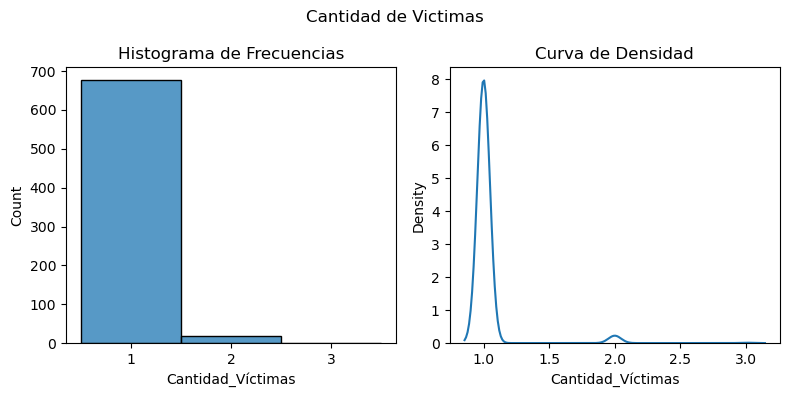

In [11]:
f, axs = plt.subplots(1,2, figsize=(8,4))

f.suptitle('Cantidad de Victimas')

sns.histplot(
    data=df_hechos,
    x='Cantidad_Víctimas',
    discrete=True,
    ax=axs[0]
)
axs[0].set_title('Histograma de Frecuencias')
axs[0].set_xticks([1,2,3])

sns.kdeplot(
    data=df_hechos,
    x='Cantidad_Víctimas',
    ax=axs[1]
)
axs[1].set_title('Curva de Densidad')

f.tight_layout()

# Guardar la figura
plt.savefig('./visual/dist_vict.png')

- La variable `Cantidad_Víctimas` presenta una variabilidad baja y se concentra altamente en la magnitud de 1.

- Obsérvese que la cantidad de víctimas fatales es en su mayoría una sola persona.

- Sin embargo, la cantidad de fallecimientos se ubica entre 1 y 3 por hecho registrado.

- Puede decirse que encontrar 3 personas fallecidas durante un siniestro vial es una poco probable.

### Contexto anual (2016 - 2021):

**Distribución temporo espacial**: Cómo se distrubuye la cantidad de víctimas a lo largo del tiempo y bajo agrupaciones temporales.

In [12]:
# Desagregar columna de la fecha
import functions as f 

# La funcion crea las columnas Año AAA, Mes con el nombre del mes
# y Dia_semana con el nombre del dia de la semana.
df_hechos = f.labeled_split_date(
    dataframe=df_hechos,
    date_column='Fecha',
    labeled_day=True,
    labeled_month=True)

Es buena idea ir guardando los datos trabajables en este notebook en un libro de Excel. Se creará en este momento con las columnas de Fecha desagregadas y se irán agregando visualizaciones tabulares que se consideren importantes, en un libro de Excel llamado "resultados".

In [13]:
df_hechos.to_excel('./data/Resultados.xlsx', sheet_name='Principal')

In [15]:
# Agrupación por año y suma de victimas
g_año = df_hechos[['Año', 'Cantidad_Víctimas',]].groupby('Año').sum()
g_año['% (sobre el total)'] = g_año / total_victimas

# Diferencia porcentual respecto al año anterior
c_actual = g_año['Cantidad_Víctimas'].values     # Valores actuales
c_anterior = g_año['Cantidad_Víctimas'].shift(1).values # Valores inmediatamente anteriores

# Cálculo de la diferencia porcentual: Actuales - Anteriores / Anteriores
g_año['Diferencia porcentual año anterior'] = (c_actual - c_anterior) / c_anterior

# Agregar al libro de excel
f.save_table_to_sheet(g_año, './data/Resultados.xlsx', 
                      sheet_name='contexto_Anual')

g_año

,Cantidad_Víctimas,% (sobre el total),Diferencia porcentual año anterior
Año,,,
2016,146,0.203626,NaN
2017,140,0.195258,-0.041096
2018,149,0.207810,0.064286
2019,104,0.145049,-0.302013
2020,81,0.112971,-0.221154
2021,97,0.135286,0.197531


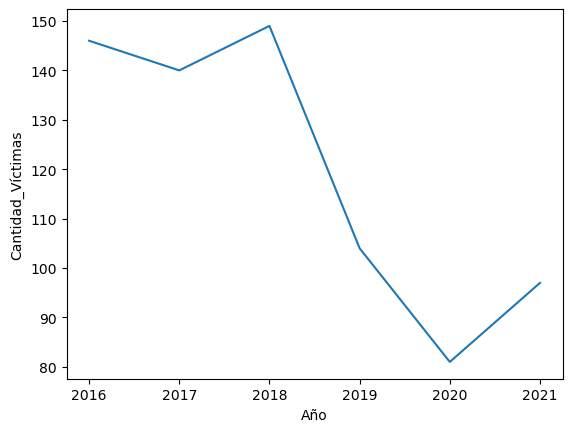

In [16]:
sns.lineplot(df_hechos, x='Año', y='Cantidad_Víctimas', estimator='sum',
             errorbar=None)

plt.savefig('./visual/vict_anual.png')

- La cantidad de himicidios en siniestros viales rondaba los 150 casos registrados durante los años 2016 a 2018.

- En el año 2019 se produjo una disminución importante, habiéndose reducido la cantidad en un 30% respecto al 2018.

- La baja continuó en el año 2020, reduciéndose un 22% respecto al 2019, alcanzando la cifra más baja de homicidios anuales durante los periodos registrados. Presenta un incremento del 22% en el 2021 y la idea es tomar medidas para que no sigan aumentando los casos.

### Victimas fatales segun el mes de ocurrencia

In [17]:
# Tabla pivote
g_meses = pd.pivot_table(
    df_hechos, columns='Año', index='Mes',
    values='Cantidad_Víctimas', aggfunc='sum')
# Columna total
g_meses['Total'] = g_meses.sum(axis=1)

f.save_table_to_sheet(g_meses,
                      path='./data/Resultados.xlsx',
                      sheet_name='Victimas_Mensuales')

g_meses

Año,2016,2017,2018,2019,2020,2021,Total
Mes,,,,,,,
Enero,8,10,14,9,8,13,62
Febrero,12,11,11,8,8,9,59
Marzo,13,12,8,11,5,7,56
Abril,11,9,15,9,3,5,52
Mayo,7,18,10,9,4,12,60
Junio,14,9,12,11,3,9,58
Julio,11,12,14,5,2,7,51
Agosto,13,9,16,14,6,9,67
Septiembre,12,13,8,9,5,4,51


Promedio mensual: 59.75
Desviación estándar mensual: 8.88
Coeficiente de Variación: 14.87 %


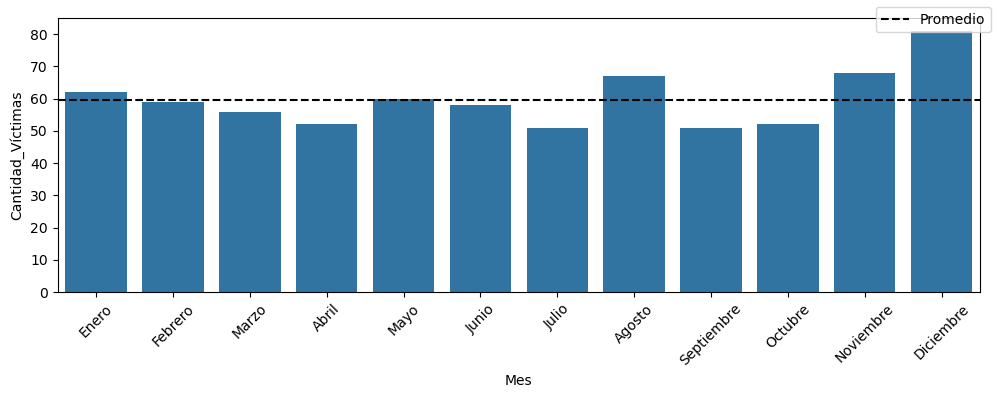

In [18]:
prom_mensual = g_meses.Total.mean()
std_mensual = g_meses.Total.std()
# Coeficiente de variacion cv
cv = (std_mensual / prom_mensual) * 100

print(f'Promedio mensual: {prom_mensual}')
print(f'Desviación estándar mensual: {round(std_mensual,2)}')
print('Coeficiente de Variación: {} %'.format(round(cv,2)))

fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(df_hechos, x='Mes', y='Cantidad_Víctimas',
            estimator='sum', ax=ax, errorbar=None)

ax.axhline(y=prom_mensual, color='black', linestyle='--', label='Promedio')

ax.tick_params(axis='x', rotation=45)

fig.legend()

fig.tight_layout()

plt.savefig('./visual/vict_mensual.png')

- **Enero, Agosto, Noviembre y Diciembre** son los meses predominantes, siendo **Diciembre el més más problemático** y en el que deberían tomarse medidas de prevención.

- El **promedio de homicidios en siniestros viales se sitúa en casi 60** víctimas, aunque **e|sta cifra varía cerca del 15%** mes a mes (obsérvese el coeficiente de variación).

### Victimas fatales segun el día de la semana

In [19]:
# Tabla pivote
g_dias = pd.pivot_table(
    df_hechos, columns='Año', index='Dia_semana',
    values='Cantidad_Víctimas', aggfunc='sum')
# Columna total
g_dias['Total'] = g_dias.sum(axis=1)

# Guardar esta tabla en el libro de resultados
f.save_table_to_sheet(g_dias, './data/Resultados.xlsx', 
                      sheet_name='Vista_DiaDeSemana')

g_dias

Año,2016,2017,2018,2019,2020,2021,Total
Dia_semana,,,,,,,
Lunes,22,33,18,8,10,16,107
Martes,16,19,18,17,18,13,101
Miercoles,27,12,24,19,4,13,99
Jueves,10,21,16,20,14,15,96
Viernes,19,18,32,12,11,10,102
Sábado,22,16,21,16,14,18,107
Domingo,30,21,20,12,10,12,105


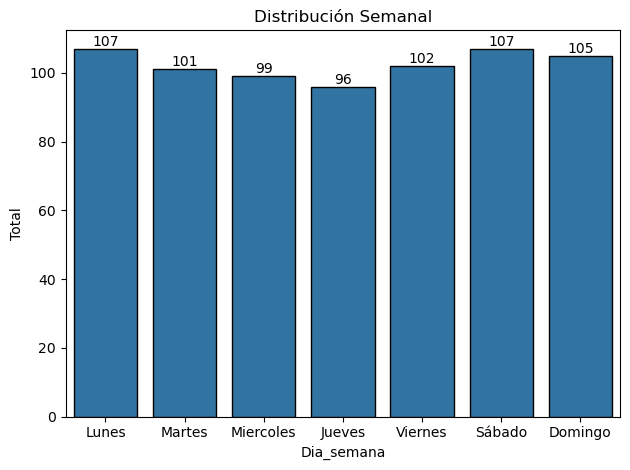

In [20]:
ax = sns.barplot(g_dias, x=g_dias.index, y='Total', edgecolor='black')
# Titulo
ax.set_title('Distribución Semanal')

# Etiquetas de barras
bar_labels = ax.containers[0]
ax.bar_label(bar_labels)

plt.tight_layout()

# Guardar la figura
plt.savefig('./visual/distribucion_semanal.png')

- Parece ser que entre semana se presentan menos accidentes fatales al día. Las cifras de homicidios son ligeramente mayores los fines de semana.

### Víctimas fatales según día de la semana y franja horaria.

In [21]:
# Tabla pivote para ver como se distribuyen las victimas 
# Dependiendo del dia y la franja horaria
g_horas = pd.pivot_table(df_hechos, values='Cantidad_Víctimas', aggfunc='sum',
               index='Hora', columns='Dia_semana').fillna(0).astype('int')

# Columna de total
g_horas['Total'] = g_horas.sum(axis=1)

# Guardar esta tabla en el libro de resultados
f.save_table_to_sheet(g_horas, './data/Resultados.xlsx', 
                      sheet_name='Vista_FranjaHoraria')

g_horas

Dia_semana,Lunes,Martes,Miercoles,Jueves,Viernes,Sábado,Domingo,Total
Hora,,,,,,,,
0,4,6,2,2,4,2,3,23
1,7,4,3,6,0,2,3,25
2,7,4,0,2,1,0,4,18
3,7,1,1,5,2,4,6,26
4,2,2,5,1,3,7,7,27
5,1,5,3,8,6,7,9,39
6,1,3,1,2,5,15,15,42
7,9,6,3,3,5,8,9,43
8,9,5,1,5,1,7,3,31


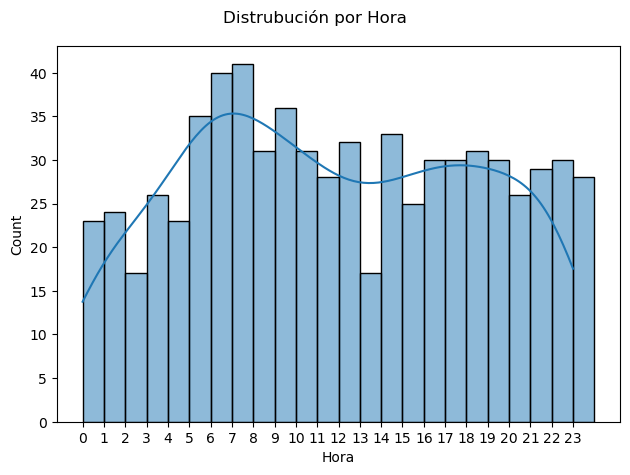

In [22]:
fig, ax = plt.subplots()

fig.suptitle('Distrubución por Hora')

bins = list(range(0,25))
sns.histplot(df_hechos,
             x='Hora',
             kde=True,
             ax=ax,
             bins=bins,
             binrange=(0,25)
        )

ax.set_xticks(range(0,24))

fig.tight_layout()

# Guardar la figura
plt.savefig('./visual/dist_horas.png')

- Si se observa con calma, puede apreciarse que **los registros más altos de himicidios se registran los Sábados y Domingos entre las 6 y 7 de la mañana.**

- De acuerdo a las cifras totales por franja horaria, puede verse que **la mayor cantidad de homicidios registrados sucede entre las 5:00 am y la 1:00 pm.** 

- El comportamiento de la distribución de victimas fatales según la franja horaria **parece coincidir con la hora pico de circulación de vehículos** en la ciudad. En la mañana, **alrededor del periodo entre las 7:00 y 8:00** y posteriormente **en el periodo alrededor de las 17:00 y 19:00**, es cuando se registran las mayores cantidades de homicidios en siniestros viales.

    - Esto último se plantea según un articulo del periódico La Nación, publicado en septiembre del 2023 en el que se expone que la horas con mayor tránsito son las 8:00 y las 18:00. Fuente (https://www.lanacion.com.ar/buenos-aires/fin-de-la-hora-pico-cuales-son-los-horarios-con-mayor-circulacion-de-vehiculos-en-las-autopistas-y-nid04092023/)

### Cantidad de homicidios por Comuna

In [24]:
# Tabla pivoteada que agrupa por comuna y permite sumar la cantidad de
# víctimas
g_comuna = pd.pivot_table(df_hechos[['Comuna', 'Cantidad_Víctimas']], 
                          values='Cantidad_Víctimas',
                          columns='Comuna',
                          aggfunc='sum')

promedio_comuna = g_comuna.mean(axis=1)

print(f'Promedio por comuna: {promedio_comuna.values}')
g_comuna

Promedio por comuna: [47.66666667]


Comuna,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
Cantidad_Víctimas,93,25,46,79,22,22,62,67,75,30,33,39,40,37,45


/tmp/ipykernel_3091/888993218.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


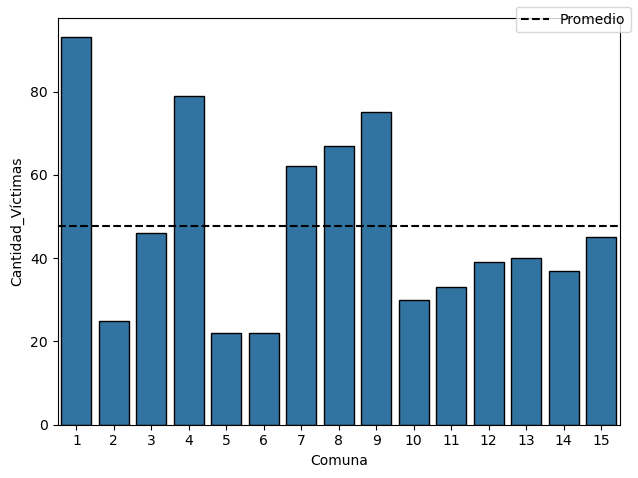

In [23]:
tick_labels = list(range(1,16))

# Se crea la figura con un par de ejes
fig, ax = plt.subplots()

# Gráfico de barras
sns.barplot(df_hechos, x='Comuna', y='Cantidad_Víctimas',
            estimator='sum', ax=ax, errorbar=None, edgecolor='black')

ax.set_xticklabels(tick_labels)

# Linear horizontal que representa el promedio
ax.axhline(promedio_comuna, color='black', linestyle='--', label='Promedio')

# Mostrar la leyenda
fig.legend()
fig.tight_layout()

plt.savefig('./visual/vict_por_comuna.png')

- Hay que prestar especial atención a las comunas **1, 4, 7, 8 y 9**. Estas see destacan al registrar una cantidad de homicidios por encima del promedio general.

- Cualquier plan de acción para tratar de reducir estos números podría ser mejor planeado y ejecutado si se sabe que hay que enfocar los esfuerzos a comunas particulares donde se presenta la problemática en mayor magnitud.

### Victimas segun tipo de Vehículo.

In [25]:
# Tabla pivote que permite agrupar por vehiculo de la victima
# y calcular la suma de la cantidad de victimas
g_victima = pd.pivot_table(df_hechos[['Vehículo_Víctima', 'Cantidad_Víctimas']],
                           columns='Vehículo_Víctima',
                           values='Cantidad_Víctimas',
                           aggfunc='sum')
g_victima

Vehículo_Víctima,Auto,Bicicleta,Cargas,Moto,Movil,Objeto Fijo,Pasajeros,Peaton,Peaton_Moto,Sd
Cantidad_Víctimas,92,29,7,302,3,2,5,266,2,9


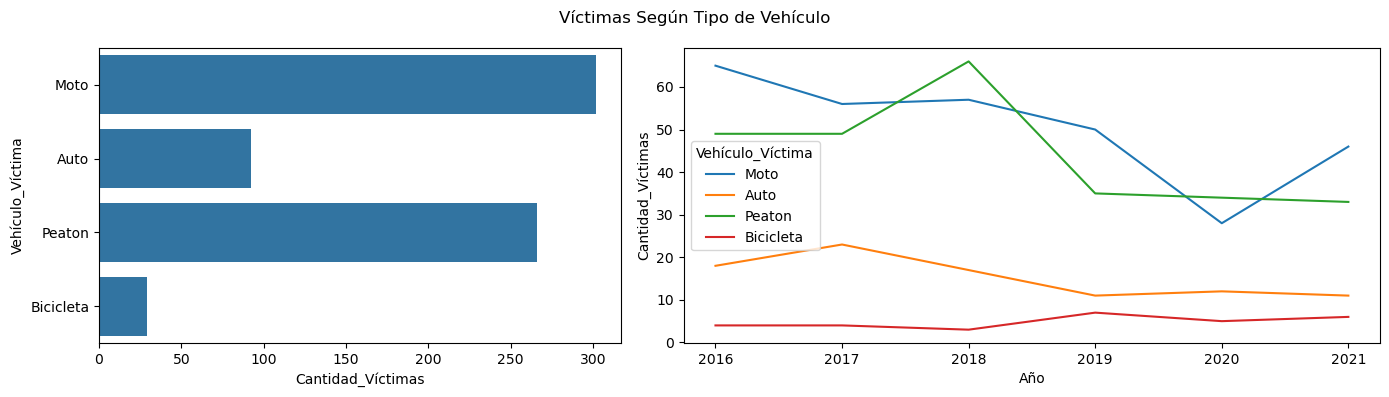

In [26]:
# Filtrar por los más frecuentes con diferencia
mascara_vehiculos = ['Moto', 'Peaton', 'Auto', 'Bicicleta']

# Aplicar la máscara 
filtrado = df_hechos[df_hechos['Vehículo_Víctima'].apply(lambda x: x in mascara_vehiculos)]

# Graficar
fig, axs = plt.subplots(1,2, figsize=(14,4), width_ratios=(3,4))

fig.suptitle('Víctimas Según Tipo de Vehículo')

sns.barplot(filtrado, y='Vehículo_Víctima', x='Cantidad_Víctimas', 
            estimator='sum', ax=axs[0], errorbar=None)

sns.lineplot(
    filtrado, x='Año', y='Cantidad_Víctimas',
    estimator='sum', hue='Vehículo_Víctima',
    ax=axs[1], err_style=None
    )

fig.tight_layout()

plt.savefig('./visual/vict_por_vehiculo.png')

- Los **motociclistas** y los **peatones** son los usuarios mayormente afectados.

- La tendencia de peatones y motociclistas siendo las principales víctimas en siniestros viales se ha mantenido duruante todos los años de los que se tienen registro.

### Víctimas segun tipo de Vía

In [27]:
g_via_años = pd.pivot_table(
    df_hechos, columns= 'Año', values='Cantidad_Víctimas',
    index='Tipo_de_calle', 
    aggfunc='sum')

g_via_años['Total'] = g_via_años.sum(axis=1)
total = pd.DataFrame(columns=g_via_años.sum().index, data=g_via_años.sum().values.reshape(1,-1))

# Guardar esta tabla en el libro de resultados
f.save_table_to_sheet(g_via_años, './data/Resultados.xlsx', 
                      sheet_name='Vista_TipoDeCalle')

pd.concat([g_via_años, total], axis=0)

Año,2016,2017,2018,2019,2020,2021,Total
Autopista,18,12,11,7,6,14,68
Avenida,91,81,93,64,52,61,442
Calle,22,29,31,27,17,12,138
Gral Paz,15,18,14,6,6,10,69
0,146,140,149,104,81,97,717


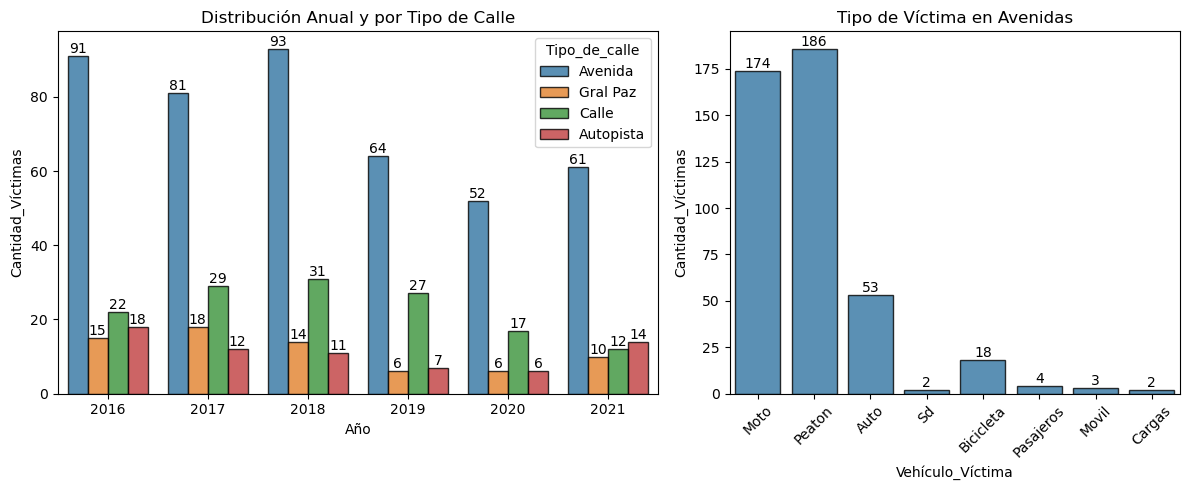

In [28]:
fig, axs = plt.subplots(1,2, figsize=(12,5), width_ratios=(4,3))

sns.barplot(
    df_hechos, x='Año', y='Cantidad_Víctimas', estimator='sum',
    hue='Tipo_de_calle', errorbar=None, alpha=0.8,
    edgecolor='black', ax=axs[0]
)

axs[0].set_title('Distribución Anual y por Tipo de Calle')
# Graficar etiquetas numéricas de barras
for i in range(4):
    axs[0].bar_label(axs[0].containers[i])

# Solo avenidas
sns.barplot(
    df_hechos[df_hechos['Tipo_de_calle'] == 'Avenida'],
    x='Vehículo_Víctima', y='Cantidad_Víctimas',
    ax=axs[1], estimator='sum', errorbar=None, edgecolor='black',
    alpha=0.8
)

axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('Tipo de Víctima en Avenidas')
axs[1].bar_label(axs[1].containers[0])

fig.tight_layout()

# Guardar gráfico
plt.savefig('./visual/vict_anual_tipo_calle.png')

- Las avenidas son el tipo de calle que registran más cantidad de homicidios por siniestros viales. Esta tendencia se mantiene a lo largo de los años.

- Si se filtran los datos para poner el foco sólo en los registros de siniestros viales en las Avenidas, el tipo de usuario que más sufre es el peatón, seguido por los motociclistas. Habría que investigar qué causa este comportamiento.

- En el siguiente gráfico se detalla el punto anterior. Véanse qué tipo de usuario es más frecuente dependiendo del tipo de calle que se observe.

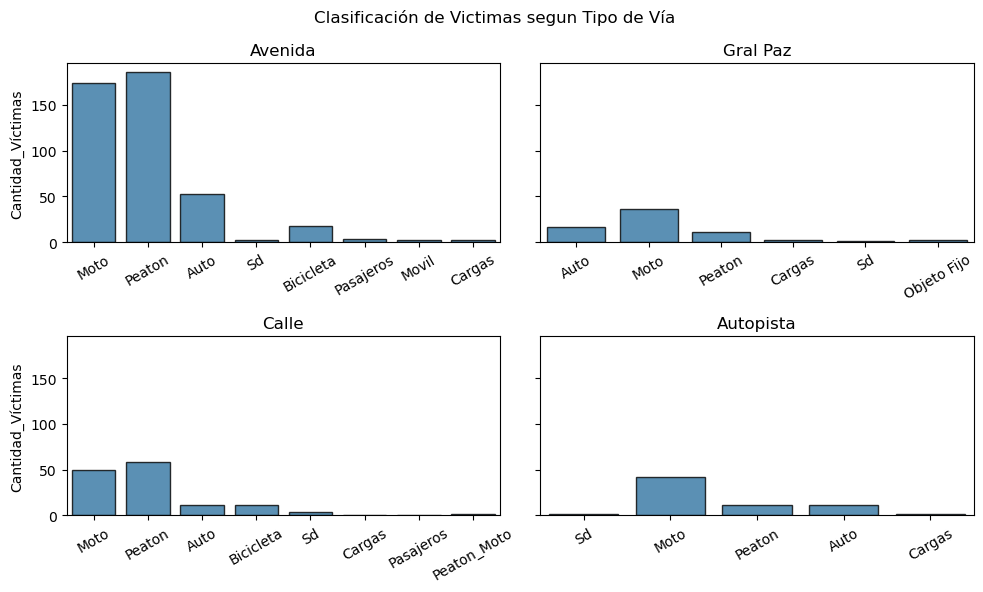

In [114]:
tipo_calle = ['Avenida', 'Gral Paz', 'Calle', 'Autopista']

fig, axs = plt.subplots(2,2, figsize = (10,6), sharey=True)

fig.suptitle('Clasificación de Victimas segun Tipo de Vía')

for index, ax in enumerate(axs.ravel()):
    sns.barplot(
        df_hechos[df_hechos['Tipo_de_calle'] == tipo_calle[index]],
        x='Vehículo_Víctima', y='Cantidad_Víctimas', estimator='sum',
        errorbar=None, alpha=0.8, edgecolor='black', ax=ax
    )
    ax.set_title(f'{tipo_calle[index]}')
    ax.tick_params(axis='x', rotation=30)
    ax.set_xlabel(None)

fig.tight_layout()

plt.savefig('./visual/vict_tipo_calle_usuario.png')

- Si bien se confirma que la magnitud de la cantidad de victimas en Avenidas es muy superior (seguida por las Calles), no se cumple que los motociclistas son los más afectados -como se habría determinado en el apartado anterior.

- El número total de motoclistas fallecidos es mayor en general, sin embargo al mirar cada tipo de calle por separado se puede notar que los peatones son los más afectados en Avenidas y Calles.

- Habría que investigar por qué los Peatones son el tipo de usuario más vulnerable cuando se trata de Avenidas y Calles.

### Víctimas Fatales: Valores Abosolutos.

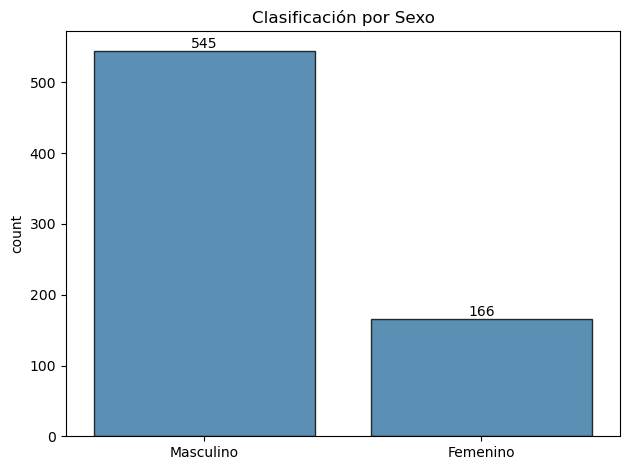

In [111]:
ax = sns.countplot(
    df_victimas,
    x='Sexo', edgecolor='black',
    alpha=0.8
)
ax.bar_label(ax.containers[0])
ax.set_title('Clasificación por Sexo')
ax.set_xlabel(None)

plt.tight_layout()

plt.savefig('./visual/dist_sexo.png')

### Victimas Fatales: Clasificación por Sexo y Tipo de Usuario.

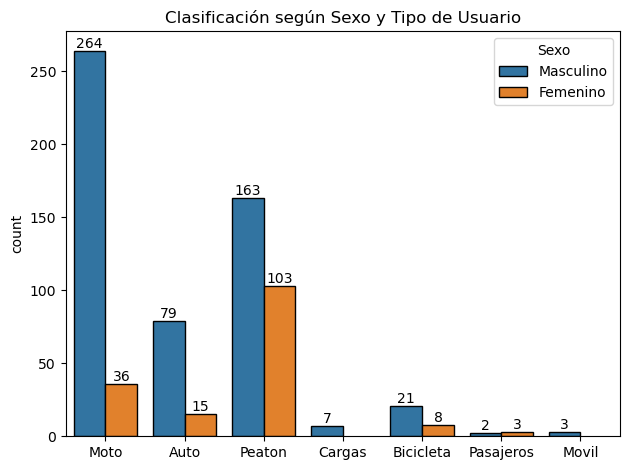

In [118]:
ax = sns.countplot(
    df_victimas,
    x='Vehículo_Víctima',
    hue='Sexo', edgecolor='black',
)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_xlabel(None)
ax.set_title('Clasificación según Sexo y Tipo de Usuario')

plt.tight_layout()

plt.savefig('./visual/dist_sex_vehiculo.png')

In [115]:
g_sex = pd.pivot_table(
    df_victimas, columns='Sexo', 
    index='Vehículo_Víctima', 
    values='ID_hecho', 
    aggfunc='count'
)

# rellenar valores nulos y pasr a entero
g_sex = g_sex.fillna(0).astype('int')

# Crear columnas de porcentajes
g_sex['Total'] = g_sex.sum(axis=1)
g_sex['(%) Femenino'] = ((g_sex['Femenino'] / g_sex['Total']) * 100).apply(round, ndigits=1).astype('str') + ' %'
g_sex['(%) Masculina'] = ((g_sex['Masculino'] / g_sex['Total']) * 100).apply(round, ndigits=1).astype('str') + ' %'

# Guardar en hoja de calculo
f.save_table_to_sheet(g_sex,'./data/Resultados.xlsx', sheet_name='Vista_SexoYVehiculo')

g_sex

Sexo,Femenino,Masculino,Total,(%) Femenino,(%) Masculina
Vehículo_Víctima,,,,,
Auto,15,79,94,16.0 %,84.0 %
Bicicleta,8,21,29,27.6 %,72.4 %
Cargas,0,7,7,0.0 %,100.0 %
Moto,36,264,300,12.0 %,88.0 %
Movil,0,3,3,0.0 %,100.0 %
Pasajeros,3,2,5,60.0 %,40.0 %
Peaton,103,163,266,38.7 %,61.3 %


- Más del 75% de las víctimas fatales son Hombres.

- La proporción desfavorable para el género masculino se mantiene en la clasificación según tipo de Usuario/Vehículo, alcanzando más del 80% en los totales para motociclistas y automóviles.